# HW3 ECE 495

## Tyler Klimas

### Problem 1  

#### import the mini MNIST dataset using sklearns datasets package, this dataset being 8 x 8 images with 900 samples

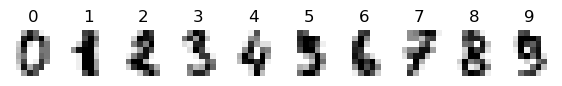

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from types import SimpleNamespace

digits = datasets.load_digits()
import matplotlib.pyplot as plt
%matplotlib inline

axes = plt.subplots(nrows=1, ncols=10, figsize=(7, 1))[1]
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(str(label))

#### In this problem we are only interested in 4 and 9, so using a mask which converts the labels to 0 and 1. This shrinks the dataset to 361 samples. After this we normalize the values by dividing by 16 to get the pixel values between 0 and 1. 

In [2]:
binary_conversion = (digits.target == 4) | (digits.target == 9)
x_binary = digits.data[binary_conversion]
y_binary = (digits.target[binary_conversion] == 9).astype(int)

x_binary /= 16.0

print(x_binary.shape),print(y_binary.shape)

(361, 64)
(361,)


(None, None)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#### I split the dataset into 60% training and 40% testing data, and then cast the values from arrays into torch.tensors which allow me to use PyTorch linear models

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_binary, y_binary, train_size=0.6, shuffle=True)
x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

print(f"Training label distribution: {np.bincount(y_train.int().numpy())}")
print(f"Testing label distribution: {np.bincount(y_test.int().numpy())}")


Training label distribution: [112 104]
Testing label distribution: [69 76]


#### I created the Logistic regression model here, a very simple linear layer which takes 64 inputs (pixel values of the image vector) and outputs a weighted sum with the weights plus a bias

#### After this, I use binary cross entropy loss with logits loss, a PyTorch package which applies the sigmoid function that outputs a "Probability" between 0 and 1.

#### I also create the optimizer function Adam which adjusts the weights of the model to minimize the loss function using back propogation. Adam is superior to SGD because it applies adaptive learning rates to each parameter. 

In [13]:
logistic_regression = nn.Linear(64, 1)
loss_function = nn.BCEWithLogitsLoss()
grad_update = optim.Adam(logistic_regression.parameters(), lr=0.01)

#### Training for 25 epochs with the Algoritm: Set the gradient to 0, predict the outputs, calculate the loss, backpropgate the loss, and then update the gradient

In [14]:
for epoch in range(25):
    grad_update.zero_grad()
    y_pred = logistic_regression(x_train).squeeze()
    loss = loss_function(y_pred, y_train)
    loss.backward()
    grad_update.step()
    if (epoch + 1) % 5 == 0:
        print(f'{epoch}, {loss.item()}')

4, 0.503761351108551
9, 0.39291465282440186
14, 0.31064847111701965
19, 0.2509492337703705
24, 0.20787371695041656


#### Here we test the model, achieving 98% accuracy 

In [15]:
with torch.no_grad():
    y_pred = torch.sigmoid(logistic_regression(x_test)).squeeze().round()
    accuracy = (y_pred == y_test).float().mean().item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred.numpy()
    y_test_np = y_test.numpy()
    print(confusion_matrix(y_test_np, y_pred_np))

Test Accuracy: 98.62%
[[69  0]
 [ 2 74]]


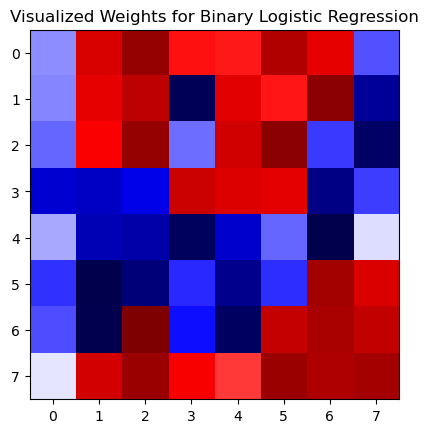

In [16]:
weights = logistic_regression.weight.detach().numpy().reshape(8, 8)

plt.imshow(weights, cmap='seismic')
plt.title('Visualized Weights for Binary Logistic Regression')
plt.show()

## Problem 2

#### This is a very similar problem, except we are introducing a hidden layer of weights to further train our model. I created a Multi Layer Perceptron with 64 hidden weights, and trained it for only 10 epochs to achieve 99% accuracy on the test set. 

In [25]:
class MLP(nn.Module):
    def __init__(self, input_size, d1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, d1)  
        self.fc2 = nn.Linear(d1, 1) 
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x)) 
        x = torch.sigmoid(self.fc2(x))
        return x

In [26]:
MLP_model = MLP(64, 64)
MLP_loss_function = nn.BCELoss()
MlP_grad_update = optim.Adam(MLP_model.parameters(), lr=0.01)

In [27]:
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    MlP_grad_update.zero_grad()
    y_pred = MLP_model(x_train).squeeze()
    loss = MLP_loss_function(y_pred, y_train)
    loss.backward()
    MlP_grad_update.step()
    if (epoch) % (NUM_EPOCHS * .1) == 0:
        print("Epoch: ", epoch, "Loss: ", loss.item())

Epoch:  0 Loss:  0.6486930251121521
Epoch:  1 Loss:  0.518378734588623
Epoch:  2 Loss:  0.404192179441452
Epoch:  3 Loss:  0.3064821660518646
Epoch:  4 Loss:  0.22734996676445007
Epoch:  5 Loss:  0.1673739105463028
Epoch:  6 Loss:  0.12467047572135925
Epoch:  7 Loss:  0.0956605076789856
Epoch:  8 Loss:  0.07646622508764267
Epoch:  9 Loss:  0.06378351151943207


In [28]:
with torch.no_grad():
    y_pred = MLP_model(x_test).squeeze().round()
    print(f'Test Accuracy: {(y_pred == y_test).float().mean() * 100:.2f}%')

Test Accuracy: 100.00%
